# UMAP chess dataset EDA

---

## Staging

---

import section:

In [284]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import umap

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

general parameters:

In [285]:
## metadata
notebook_ver = 0.2

## dataset
data_pth = './data/games.csv'

## Define nominal data variables to be thrown at one-hot-encoder
to_hot_encode = [
    'opening_eco',
    'increment_code',
    'victory_status'
]

## Define string variables for vectorization
to_vectorize = [
    'white_id',
    'black_id'
]

## Define numerical cols to use
num_cols = [
    'winner_bin',
    'rated_bin',
    'game_len_mins',
    'turns', # dense var
#     'white_rating', # dense var
#     'black_rating', # dense var
    'opening_ply'
]

Data load:

In [286]:
games = pd.read_csv(data_pth)

## Preprocessing

---

In [287]:
## Encode binary vars to integers
games['rated_bin'] = np.where(games['rated'] == True, 1, 0)

games.drop(columns='rated',
          inplace=True)

In [288]:
games['winner_bin'] = np.where(games['winner'] == 'white', 0, 1)

games.drop(columns='winner',
          inplace=True)

In [289]:
## Opening, closing games dates transformation
games['created_at_dt'] = pd.to_datetime(games['created_at']/1000, unit='s', origin='unix')
games['last_move_at_dt'] = pd.to_datetime(games['last_move_at']/1000, unit='s', origin='unix')

games['game_len_dt'] = games['last_move_at_dt'] - games['created_at_dt']
games['game_len'] = games['last_move_at'] - games['created_at']

games['game_len_mins'] = games['game_len_dt'].dt.components['minutes']

In [290]:
## Instantiate One Hot Encoder
ohe = OneHotEncoder(handle_unknown='error')

In [291]:
## Instantiate Count Vectorizer
cve = CountVectorizer()

In [292]:
## Set column transformer
column_trans = make_column_transformer((ohe,to_hot_encode),
                                       remainder='passthrough')

In [293]:
## Fit column transformer
column_trans.fit(games[to_hot_encode])

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['opening_eco', 'increment_code',
                                  'victory_status'])])

In [294]:
## Produce one-hot-encoded array 
hot_encoded = column_trans.transform(games[to_hot_encode]).toarray()

hot_encoded_df = pd.DataFrame(hot_encoded, 
                              columns = column_trans.get_feature_names())

/home/nef/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [295]:
## Form final dataframe
hot_df = games[num_cols].merge(hot_encoded_df,
                     left_index=True,
                     right_index=True)

## Final DF

---

In [296]:
hot_df

,winner_bin,rated_bin,game_len_mins,turns,opening_ply,onehotencoder__x0_A00,onehotencoder__x0_A01,onehotencoder__x0_A02,onehotencoder__x0_A03,onehotencoder__x0_A04,...,onehotencoder__x1_9+9,onehotencoder__x1_90+0,onehotencoder__x1_90+120,onehotencoder__x1_90+30,onehotencoder__x1_90+5,onehotencoder__x1_90+8,onehotencoder__x2_draw,onehotencoder__x2_mate,onehotencoder__x2_outoftime,onehotencoder__x2_resign
0,0,0,0,13,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,0,16,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,1,0,61,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,1,0,61,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1,0,95,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,0,1,5,24,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20054,1,1,12,82,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20055,0,1,2,35,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20056,0,1,15,109,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## UMAP model

---

Parameters:

In [297]:
distance_metric = 'euclidean'
# metrics_available = euclidean, manhattan, chebyshev, minkowski, canberra, braycurtis, mahalanobis,
# wminkowski, seuclidean, cosine, correlation, haversine, hamming, jaccard, dice, russelrao, kulsinski,
# ll_dirichlet, hellinger, rogerstanimoto, sokalmichener, sokalsneath, yule

n_neighbors = 15
min_dist = 0.2

Instatiate & train the model:

In [298]:
## Instantiate UMAP model
reducer = umap.UMAP(metric=distance_metric,
                   n_neighbors=n_neighbors,
                   min_dist=min_dist)

In [299]:
## Train the model
embedding = reducer.fit_transform(hot_df)

---

## Plot

---

Parameters:

In [300]:
## switches
cbar_switch = True

## display
alpha = 1
marker_shape = 'o'
marker_size = 2
dpi = 300

## data
cmap_variable = games['game_len_mins']

## colors
facecolor = 'black'
labelcolor = 'white'
cmap = 'viridis'

Plot script:

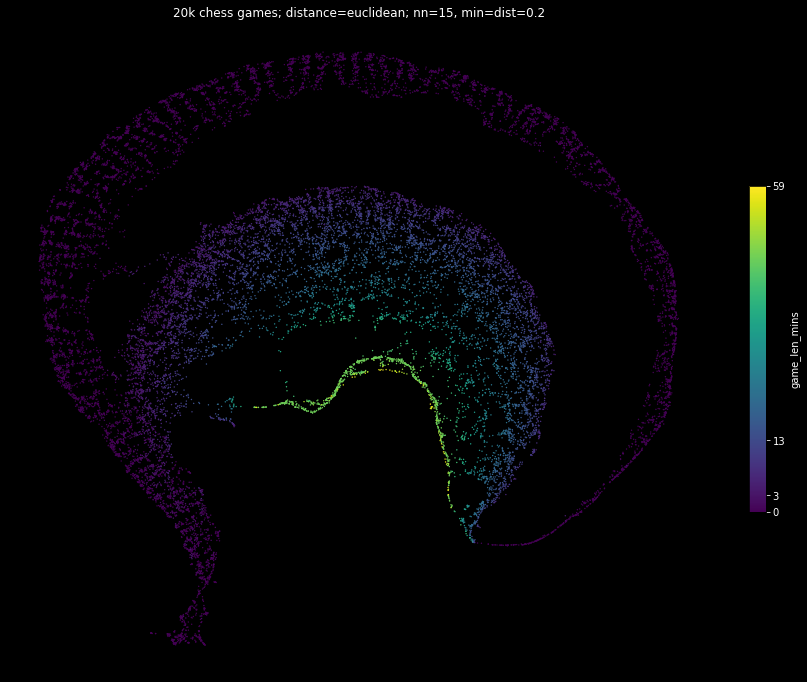

In [304]:
## Render vis
fig = plt.figure(figsize=(14,12))
fig.patch.set_facecolor(facecolor)

plot = plt.scatter(embedding[:,0], 
                embedding[:,1], 
                marker=marker_shape,
                s=marker_size,
                edgecolor='none',
                c=cmap_variable,
                cmap='viridis', 
                alpha=alpha)

plt.axis("off")
plt.title(f'20k chess games; distance={distance_metric}; nn={n_neighbors}, min=dist={min_dist}', 
          color='w')

if cbar_switch:
    cbar = plt.colorbar(fraction=0.05, 
                    shrink=0.5,
                    ticks=[games['game_len_mins'].min(), 
                        games['game_len_mins'].quantile(q=0.50),
                        games['game_len_mins'].quantile(q=0.75),
                        games['game_len_mins'].max()], alpha=alpha
                           )

    cbar.set_label(cmap_variable.name, color=labelcolor)
    cbar.ax.yaxis.set_tick_params(color=labelcolor)
    cbar.solids.set_edgecolor("face")

plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=labelcolor)

_ = plot

plt.savefig(f"screens/{distance_metric}_nn{n_neighbors}_mind{min_dist}_v{notebook_ver}.png", 
            dpi=dpi, 
            facecolor=facecolor)